<a href="https://colab.research.google.com/github/marvin-hansen/fastai/blob/master/Lesson_2_fast_ai.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lesson 2

Data cleaning and production; SGD from scratch
https://course.fast.ai/videos/?lesson=2

We start today's lesson learning how to build your own image classification model using your own data, including topics such as:

* Image collection
* Parallel downloading
* Creating a validation set, and
* Data cleaning, using the model to help us find data problems.


I'll demonstrate all these steps as I create a model that can take on the vital task of differentiating teddy bears from grizzly bears. Once we've got our data set in order, we'll then learn how to productionize our teddy-finder, and make it available online.

We've had some great additions since this lesson was recorded, so be sure to check out:

* The production starter kits on the course web site, such as this one for deploying to Render.com
* The new interactive GUI in the lesson notebook for using the model to find and fix mislabeled or incorrectly-collected images.



In the second half of the lesson we'll train a simple model from scratch, creating our own gradient descent loop. In the process, we'll be learning lots of new jargon, so be sure you've got a good place to take notes, since we'll be referring to this new terminology throughout the course (and there will be lots more introduced in every lesson from here on).


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
#batch size 

bs = 64
# bs = 32 
# bs = 16   # uncomment this line if you run out of memory even after clicking Kernel->Restart

**bold text**## Import Fast.ai & PyTorch


In [0]:
import fastai
from fastai import *
from fastai.basics import *
from fastai.vision import *
from fastai.metrics import error_rate

import matplotlib.pyplot as plt
from PIL import Image

print("FastAI Version: " + str(fastai.__version__))


FastAI Version: 1.0.48


In [0]:
import torch

print("PyTorch Version: " + str(torch.__version__))

PyTorch Version: 1.0.1.post2


## Check GPU *acceleration*

In [0]:
torch.cuda.current_device()

print("Cude available: " + str(torch.cuda.is_available()))
print("Cude enabled:" + str(torch.backends.cudnn.enabled))

#https://stackoverflow.com/questions/48152674/how-to-check-if-pytorch-is-using-the-gpu
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print("GPU used: " + torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Cude available: True
Cude enabled:True
Using device: cuda

GPU used: Tesla K80
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Mount GDrive to store data 


In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'fastai-v3/'

!ls

Mounted at /content/gdrive
gdrive	sample_data  ta-lib  ta-lib-0.4.0-src.tar.gz


## Stochastic Gradient Descent (SGD)

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an optimization method commonly used in neural networks. We will illustrate the concepts with concrete example

## Linear Regression problem¶

The goal of linear regression is to fit a line to a set of points.




In [0]:
n=100

x = torch.ones(n,2) 
x[:,0].uniform_(-1.,1)
x[:5]

tensor([[-0.4203,  1.0000],
        [ 0.5535,  1.0000],
        [-0.8168,  1.0000],
        [-0.5180,  1.0000],
        [-0.6866,  1.0000]])

In [0]:
a = tensor(3.,2); a


tensor([3., 2.])

In [0]:
y = x@a + torch.rand(n)


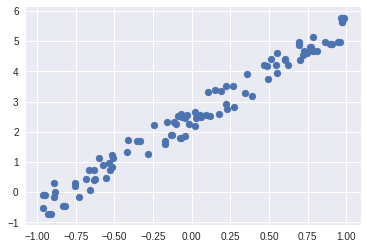

In [0]:
plt.scatter(x[:,0], y);



You want to find parameters (weights) a such that you minimize the error between the points and the line x@a. 
Note that here a is unknown. For a regression problem the most common error function or loss function is the mean squared error.


In [0]:
def mse(y_hat, y): return ((y_hat-y)**2).mean()


In [0]:
# Suppose we believe a = (-1.0,1.0) then we can compute y_hat which is our prediction and then compute our error.

a = tensor(-1.,1)
y_hat = x@a
mse(y_hat, y)

tensor(8.4688)

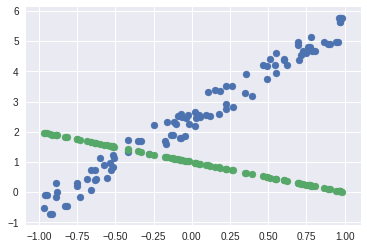

In [0]:

plt.scatter(x[:,0],y)
plt.scatter(x[:,0],y_hat);


So far we have specified the model (linear regression) and the evaluation criteria (or loss function). Now we need to handle optimization; that is, how do we find the best values for a? How do we find the best fitting linear regression.

## Gradient Descent¶

We would like to find the values of a that minimize mse_loss.

Gradient descent is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in PyTorch.

In [0]:
a = nn.Parameter(a); a

def update():
    y_hat = x@a
    loss = mse(y, y_hat)
    if t % 10 == 0: print(loss)
    loss.backward()
    with torch.no_grad():
        a.sub_(lr * a.grad)
        a.grad.zero_()

In [0]:
lr = 1e-1
for t in range(100): update()

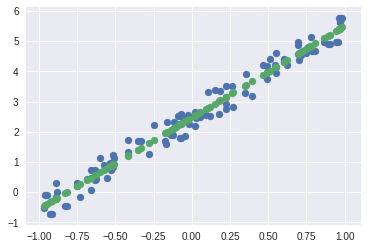

In [0]:
plt.scatter(x[:,0],y)
plt.scatter(x[:,0],x@a);

In [0]:
from matplotlib import animation, rc
rc('animation', html='jshtml')

a = nn.Parameter(tensor(-1.,1))

fig = plt.figure()
plt.scatter(x[:,0], y, c='orange')
line, = plt.plot(x[:,0], x@a)
plt.close()

def animate(i):
    update()
    line.set_ydata(x@a)
    return line,

animation.FuncAnimation(fig, animate, np.arange(0, 100), interval=20)

In practice, we don't calculate on the whole file at once, but we use mini-batches.

**Vocab**
* Learning rate (multiplier of the gradient required to for SGD)
* error rate ( 1- accuracy)
* Accuracy (mean value of correctly predicted values)
* Epoch (one complete run through all images )
 - in general, not too many to prevent overfitting 
* Minibatch (subset of the entire dataset)
* SGD (gradient descent)
* Model / Architecture (mathematically function to fit the data)
* Parameters / weights (updated to fit the curve)
* Loss function (how close / far from the correct answers)


For classification problems, we use cross entropy loss, also known as negative log likelihood loss. This penalizes incorrect confident predictions, and correct unconfident predictions.

In [0]:
doc(accuracy)